In [37]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [34]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [20]:
numeric_columns = house_df.select_dtypes(['int64','float64']).columns
print(numeric_columns)

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')


In [5]:
house_df = pd.concat([house_df, pd.get_dummies(house_df.neighborhood, prefix="neighborhood", drop_first=True)], axis=1)

house_df = pd.concat([house_df, pd.get_dummies(house_df.housestyle, prefix="housestyle", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(house_df.neighborhood, prefix="neighborhood", drop_first=True).columns)

dummy_column_names = list(pd.get_dummies(house_df.housestyle, prefix="housestyle", drop_first=True).columns)

In [24]:
Y = house_df["saleprice"]
X = house_df[["overallqual", "firstflrsf", "garagecars", "totalbsmtsf", "grlivarea"] + dummy_column_names]

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 2.42761020e+04 -2.95523491e+01  1.64631220e+04  2.43747724e+01
  7.90551806e+01  1.71261077e+04  3.22049722e+04 -4.47767887e+04
 -4.34759910e+04 -3.59428389e+03  3.37906688e+04  2.27583270e+04]

Intercept: 
 -123839.87238719032


In [25]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the house prices model is: {}".format(np.mean(errors)))

Mean of the errors in the house prices model is: 3.3888021764689927e-12


It appears that the 2nd assumption is nearly zero. For all intents and purposes this is pretty close to 0. This assumption can be confirmed.

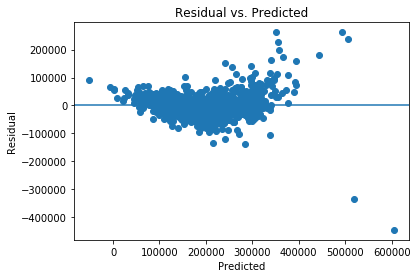

In [26]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [35]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} p-value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} p-value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 508.336 p-value is 1.46e-112
Levene test statistic value is 486.998 p-value is 6.19e-100


The p-value for both tests are less than .05, so we can dismiss the null hypothesis and assume this assumption is false. 

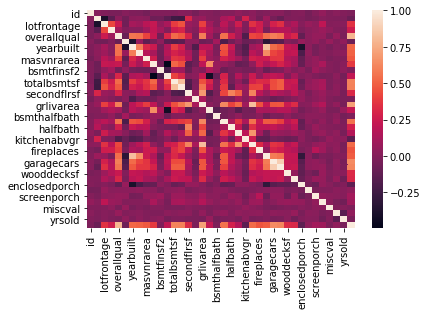

In [41]:
sns.heatmap(house_df.corr())

Looking at the heatmap, it does not appear that there is any large correlations in the dataset. So the fourth assumption can be confirmed.

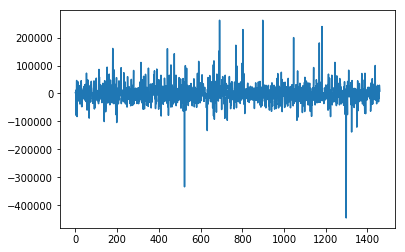

In [30]:
plt.plot(errors)
plt.show()

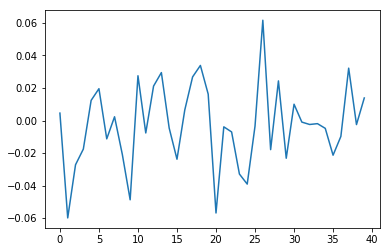

In [31]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.show()

The graphs both show no correlation with one another. This confirms this assumption.

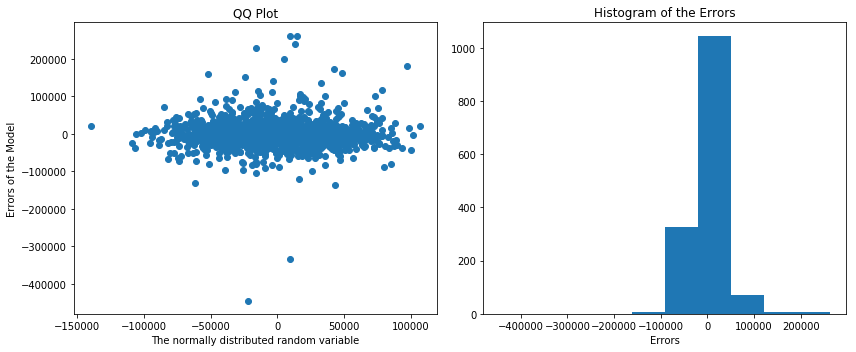

In [32]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(rand_nums, errors)
plt.xlabel("The normally distributed random variable")
plt.ylabel("Errors of the Model")
plt.title("QQ Plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("Errors")
plt.title("Histogram of the Errors")

plt.tight_layout()
plt.show()

In [33]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p-value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normal Test statistics is {0} and p-value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 32007.36207126469 and p-value is 0.0
Normal Test statistics is 416.0458634137241 and p-value is 4.5372075947953554e-91


Both the graphs and the statistics support that the 6th assumption is false. The graphs do not show "normal" distribution and the p-values are less than .05. 

We can confirm 4 out of the 6 assumptions with the house prices model. Depending on how many we need to confirm this model, we can have some validity to the coefficients and the statistics taken from the data.